In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)

import numpy as np
import matplotlib.pyplot as plt

import ceedub as cw

%matplotlib inline

# `ceedub` Basic Usage

## generating simulated data

To show the capabilities of `ceedub` we will simulate some time domain data using `numpy`.  The data will be a sum of sine-Gaussians.

In [3]:
def sin_gauss(t, t0=0, f0=1, tau=1, A=1, phi=0):
    """generate a Gaussian windowed sinusoidal signal
    
    g(t) = A*sin(2*pi*f0*(t-t0) + phi) * exp(-(t-t0)**2/(2*tau))
    
    :param t:
        evaluation time or numpy array-like list of times
    :param t0:
        central time of signal
    :param f0:
        central frequency of signal
    :param tau:
        time constant (damping time) of signal
    :param A:
        amplitude of signal
    :param phi:
        phase offset of signal
    """
    t = np.asarray(t)
    osc = np.sin(2*np.pi*f0 * (t-t0))
    win = np.exp(-0.5*(t-t0)**2/tau**2)
    return A * osc * win

We will simulate 4 seconds of data sampled at 256 Hz, containing three sine-Gaussians.

In [28]:
Tobs = 4  # sec
dt = 1/256  # sec

ts = np.arange(0, Tobs, dt)

tdat = (sin_gauss(ts, t0=2, f0=8, tau=1)
        + sin_gauss(ts, t0=1, f0=32, tau=1/8, A=2)
        + sin_gauss(ts, t0=3, f0=16, tau=1/4))

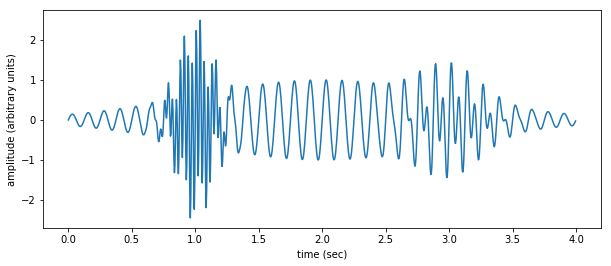

In [29]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(ts, tdat)
ax.set_xlabel("time (sec)")
ax.set_ylabel("amplitude (arbitrary units)")

## using `_easy` CWTs

We will use the `ceedub.cwt()` method to perform a **continuous wavelet transform (CWT)** using the default settings.

The `ceedub.cwtfreq()` method outputs the frequency scales used in the default CWT.  This method is named to remind the user of `numpy.fft.fftfreq()`, which gives the Fourier frequencies from a Fourier transform.

We will use the frequencies to plot a spectrogram using `matplotlib.pyplot.pcolormesh()`

In [30]:
N = len(tdat)
wdat = cw.cwt(tdat, dt)
freqs = cw.cwtfreq(N, dt)

`wdat` is a complex array of wavelet amplitude data for each sample time and frequency scale, $a(t,f)$.  To plot this as a **spectrogram** we need to compute the wavelet power, $p(t,f)$,

$$p = | a |^2$$

which is real valued.

In [31]:
pdat = np.abs(wdat)**2

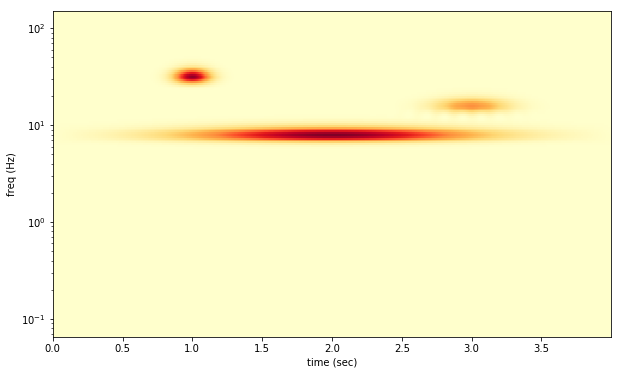

In [32]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.pcolormesh(ts, freqs, pdat, cmap='YlOrRd')
ax.set_yscale('log')
ax.set_xlabel("time (sec)")
ax.set_ylabel("freq (Hz)")

In the wavelet domain our three overlapping sine-Gaussians clearly separate due to their differing frequency content.

### ICWT

We can compute the **inverse CWT** using the default basis with the `ceedub.icwt()` method.  This reconstructs the time domain signal from the wavelet domain data.

In [33]:
invdat = cw.icwt(wdat, dt)

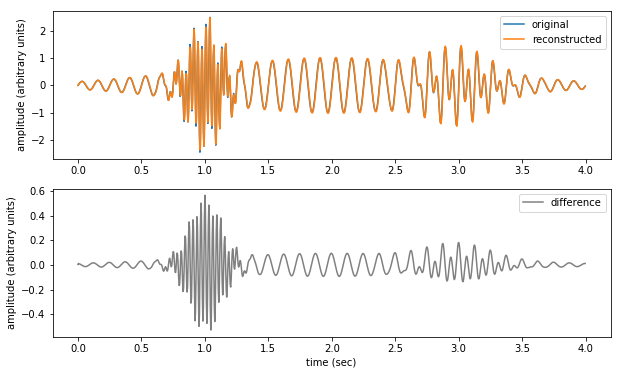

In [45]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax1.plot(ts, tdat, label='original')
ax1.plot(ts, invdat, label='reconstructed')

ax2 = fig.add_subplot(212)
ax2.plot(ts, tdat-invdat, label='difference', color='grey')

ax2.set_xlabel("time (sec)")
for ax in [ax1, ax2]:
    ax.set_ylabel("amplitude (arbitrary units)")
    ax.legend()

While differences may appear small on an overlay, the reconsctruction can have errors on the order of 10%.  The problem is worst for high frequencies.  In general the closer the frequency of interest is to the Nyquist frequency, the greater the reconstruciton error.  The default transforms are meant to be quick and dirty.  The forward transform **works**.  The inverse transform works, but can introduce error in some cases.

If you plan on doing several transforms or want more control to tune your transforms you should use a `WaveletBasis` object.